In [1]:
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import pickle

In [2]:
# Properties of artificial watershed
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [3]:
rate10 = [ 12,  30,  63,  75,  84,  87 ,90,  93.5,  95,  96.01,  97.44,  97.44 ,  99.42,  99.42, 99.67,  100] # resolution 30min

forcing, cum_forcing, forcing_hour = Generate_SyntheticStorm(150,24, rate=(0.01*np.diff(rate10, prepend=0)).tolist(), timescale=30)
te = len(forcing)-1

with open('../data/supplement/initial_condition.pickle', 'rb') as ini_file:
    initial_condition = pickle.load(ini_file)



# Several scenarios for dam spatial configurations are created:

<ul>
  <li>Scenario-1</li>
  <p> There are only two big ponds on Links 81 and 162 (order-5 streams). Total drainage area of each dam is 20.25 km<sup>2</sup></p>
  <li>Scenario-2</li>
  <p> There are four small ponds on order 4 links. Total drainage area of each dam is 6.75 km<sup>2</sup></p>
  <li>Scenario-3</li>
  <p> There are ten small ponds on order 3 links. Total drainage area of each dam is 2.25 km<sup>2</sup></p>
  <li>Scenario-4</li>
  <p> The dams in scenario-2 and scenario-3 placed all together .</p>
  <li>Scenario-5</li>
  <p> in addition to the dams in scenario-4, five more dams are placed on order 4 and order3 streams that are closer to the outlet to control more area. </p>

</ul>

In [4]:
dams1  = [81, 162] # two big ponds (SCENARIO-1)
dams2 = [189, 216, 135, 108,] # dams on order_4 Note: No dams on the links closer to the outlet (SCENARIO-2)
dams3 = [117,126,144,153,198,207,225,234] ## dams on order_3 Note: No dams on the links closer to the outlet (SCENARIO-3)
dams4 = dams2 + dams3 ## dams on order_3 and order_4 Note: No dams on the links closer to the outlet  (SCENARIO-4)
dams5 = [27, 189, 216, 135, 108,] + [9,36,45,63,90,117,126,144,153,171,198,207,225,234]   ## dams on order_3 and order_4 Note: dams on the links closer to the outlet included (SCENARIO-5)
n_dams1 = len(dams1)
n_dams2 = len(dams2)
n_dams3 = len(dams3)
n_dams4 = len(dams4)
n_dams5 = len(dams5)

In [5]:
SSN1 = Watershed(Model=256)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest = PrepareDamParams(dams1) #!! TODO: make the code run without this parameters when no dam introduced
dam_params256 = SSN1.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest) # !!
q = initial_condition['q']
s_p = initial_condition['s_p']
s_t = initial_condition['s_t']
s_s = initial_condition['s_s']
SSN1.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
SSN1.set_dam_state()
dc_nodam, _ = SSN1.Run_256( [0, te-1],forcing, dam_params256,rtol=1e-6, )

    

Model 256 (254 with_dams) is being used!
No dam is set!
INFO: No dam is set!
No dam is set!


In [6]:
SSN2 = Watershed(Model=256)
SSN2.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN2.dam_ids = dams1
H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest = PrepareDamParams(dams1)
dam_params256 = SSN2.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q = initial_condition['q']
s_p = initial_condition['s_p']
s_t = initial_condition['s_t']
s_s = initial_condition['s_s']
fill_percent = np.repeat([0.7], n_dams1)
S = (S_max * fill_percent).tolist()
SSN2.set_dam_state(states=[1 for _ in range(len(dams1))])
SSN2.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)
dc_passive_S1, st_passive_S1 = SSN2.Run_256( [0, te], forcing, dam_params256)
out_passive_S1 = SSN2.CalculateOutflow(dam_params256, st_passive_S1)

Model 256 (254 with_dams) is being used!


In [7]:
SSN3 = Watershed(Model=256)
SSN3.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN3.dam_ids = dams2
H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest = PrepareDamParams(dams2)
dam_params256 = SSN3.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q = initial_condition['q']
s_p = initial_condition['s_p']
s_t = initial_condition['s_t']
s_s = initial_condition['s_s']
fill_percent = np.repeat([0.7], n_dams2)
S = (S_max * fill_percent).tolist()
SSN3.set_dam_state(states=[1 for _ in range(len(dams2))])
SSN3.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)
dc_passive_S2, st_passive_S2 = SSN3.Run_256( [0, te], forcing, dam_params256)
out_passive_S2 = SSN3.CalculateOutflow(dam_params256, st_passive_S2)

Model 256 (254 with_dams) is being used!


In [8]:
SSN4 = Watershed(Model=256)
SSN4.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN4.dam_ids = dams3
H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest = PrepareDamParams(dams3)
dam_params256 = SSN4.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q = initial_condition['q']
s_p = initial_condition['s_p']
s_t = initial_condition['s_t']
s_s = initial_condition['s_s']
fill_percent = np.repeat([0.7], n_dams3)
S = (S_max * fill_percent).tolist()
SSN4.set_dam_state(states=[1 for _ in range(len(dams3))])
SSN4.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)
dc_passive_S3, st_passive_S3 = SSN4.Run_256( [0, te], forcing, dam_params256)
out_passive_S3 = SSN4.CalculateOutflow(dam_params256, st_passive_S3)

Model 256 (254 with_dams) is being used!


In [9]:
SSN5 = Watershed(Model=256)
SSN5.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN5.dam_ids = dams4
H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest = PrepareDamParams(dams4)
dam_params256 = SSN5.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q = initial_condition['q']
s_p = initial_condition['s_p']
s_t = initial_condition['s_t']
s_s = initial_condition['s_s']
fill_percent = np.repeat([0.7], n_dams4)
S = (S_max * fill_percent).tolist()
SSN5.set_dam_state(states=[1 for _ in range(len(dams4))])
SSN5.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)
dc_passive_S4, st_passive_S4 = SSN5.Run_256( [0, te], forcing, dam_params256)
out_passive_S4 = SSN5.CalculateOutflow(dam_params256, st_passive_S4)

Model 256 (254 with_dams) is being used!


In [10]:
SSN6 = Watershed(Model=256)
SSN6.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN6.dam_ids = dams5
H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest = PrepareDamParams(dams5)
dam_params256 = SSN6.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q = initial_condition['q']
s_p = initial_condition['s_p']
s_t = initial_condition['s_t']
s_s = initial_condition['s_s']
fill_percent = np.repeat([0.7], n_dams5)
S = (S_max * fill_percent).tolist()
SSN6.set_dam_state(states=[1 for _ in range(n_dams5)])
SSN6.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)
dc_passive_S5, st_passive_S5 = SSN6.Run_256( [0, te], forcing, dam_params256)
out_passive_S5 = SSN6.CalculateOutflow(dam_params256, st_passive_S5)

Model 256 (254 with_dams) is being used!


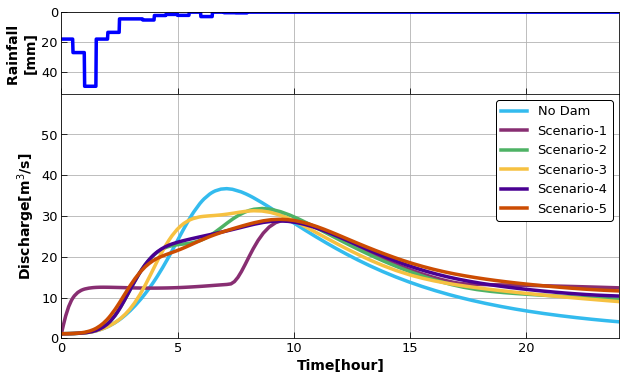

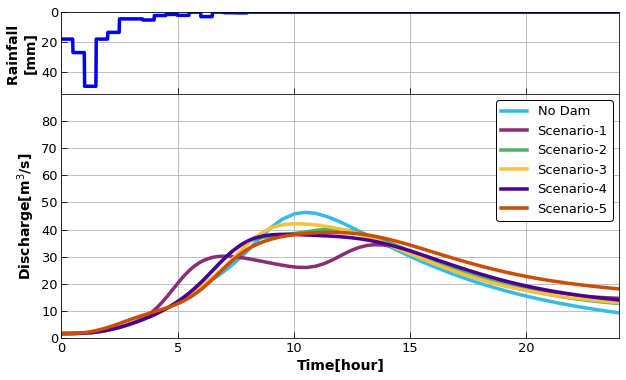

In [12]:
pltkwargs = np.array([{'label':'No Dam', 'color':'#33bbee'}, {'label':'Scenario-1', 'color':'#882e72',},{'label':'Scenario-2', 'color':'#4eb265','linestyle':'solid'},{'label':'Scenario-3', 'color':'#f6c141','linestyle':'solid'},{'label':'Scenario-4', 'color':'#490092'},{'label':'Scenario-5', 'color':'#cc4c02'}])

pltKwargs = pltkwargs[[0,1, 2, 3,4,5]]
dataset = [dc_nodam, dc_passive_S1,dc_passive_S2,dc_passive_S3,dc_passive_S4,dc_passive_S5]
# plot_sim([0,162, 188], forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,220,20], fig_size=(10, 6))
plot_sim(80, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,60,10],fig_size=(10, 6))
plot_sim(0, forcing, dataset, pltKwargs, d_type='discharge', discharge_axis=[0,90,10],fig_size=(10, 6))




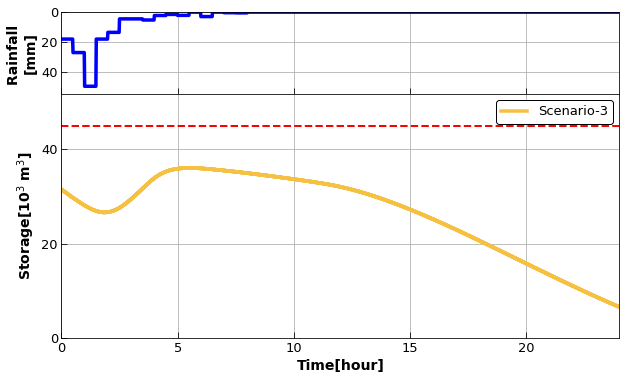

In [13]:
pltKwargs = pltkwargs[[3]]
dataset = [st_passive_S3]
# plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', max_storage=60000, storage_int=10)
plot_sim(dams3, forcing, dataset, pltKwargs, d_type='storage',max_storage=45000, storage_int=20,fig_size=(10, 6))

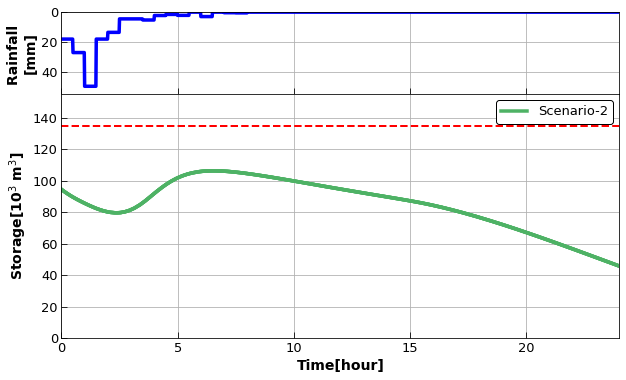

In [14]:
pltKwargs = pltkwargs[[2]]
dataset = [st_passive_S2]
# plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', max_storage=60000, storage_int=10)
plot_sim(dams2, forcing, dataset, pltKwargs, d_type='storage', max_storage=135000,storage_int=2,fig_size=(10, 6))

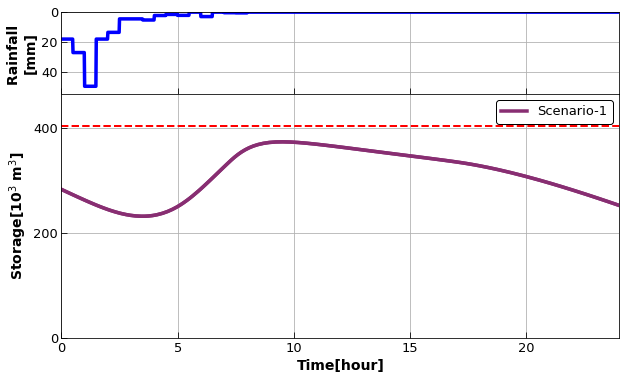

In [15]:
pltKwargs = pltkwargs[[1]]
dataset = [st_passive_S1]
# plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', max_storage=60000, storage_int=10)
plot_sim(dams1, forcing, dataset, pltKwargs, d_type='storage', max_storage=405000,storage_int=20,fig_size=(10, 6))

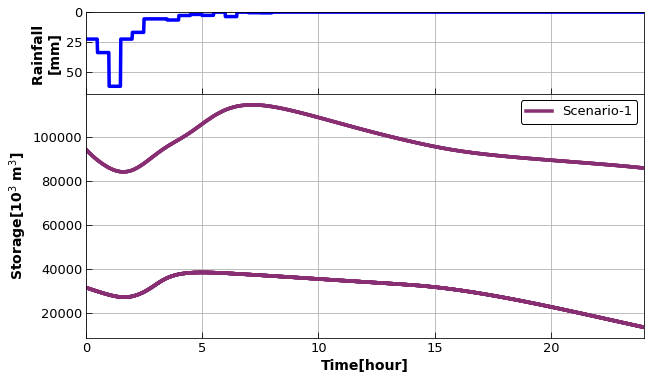

In [101]:
pltKwargs = pltkwargs[[1]]
dataset = [st_passive_S4]
# plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', max_storage=60000, storage_int=10)
plot_sim(dams4, forcing, dataset, pltKwargs, d_type='storage', storage_int=20,fig_size=(10, 6))

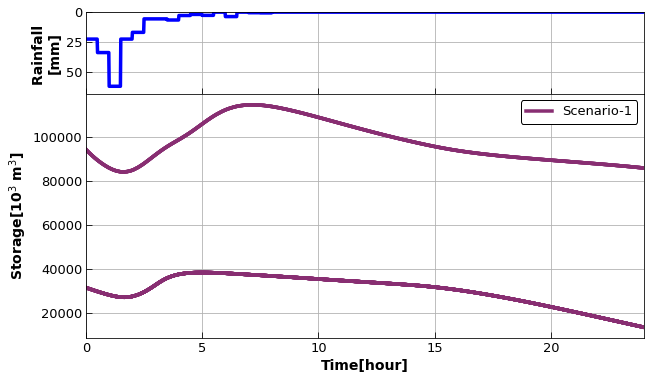

In [102]:
pltKwargs = pltkwargs[[1]]
dataset = [st_passive_S5]
# plot_sim(order_3, forcing, dataset, pltKwargs, d_type='storage', max_storage=60000, storage_int=10)
plot_sim(dams5, forcing, dataset, pltKwargs, d_type='storage', storage_int=20,fig_size=(10, 6))

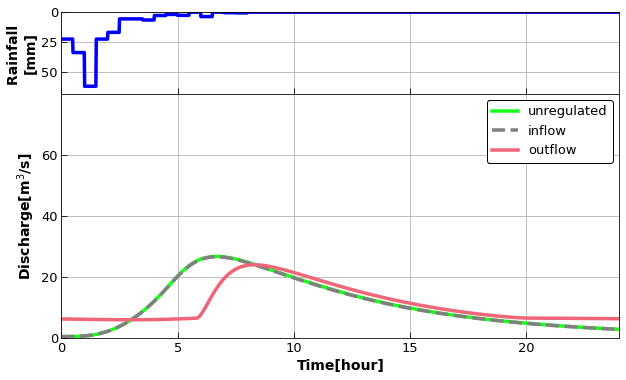

In [103]:
in_out_Kwargs = np.array([{'label':'unregulated', 'color':'#1AFF1A'},{'label':'inflow', 'color':'gray','linestyle':'dashed'},{'label':'outflow', 'color':'#ee6677'}],)

dataset = [dc_nodam, dc_passive_S1, out_passive_S1]
plot_sim(dams1[0], forcing, dataset, in_out_Kwargs[[0,1, 2]], d_type='discharge', discharge_axis=[0,80,20],fig_size=(10, 6))

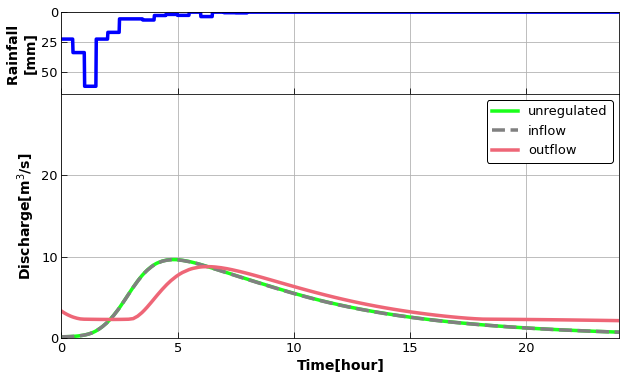

In [104]:
in_out_Kwargs = np.array([{'label':'unregulated', 'color':'#1AFF1A'},{'label':'inflow', 'color':'gray', 'linestyle':'dashed'},{'label':'outflow', 'color':'#ee6677'}],)

dataset = [dc_nodam, dc_passive_S2, out_passive_S2]
plot_sim(dams2[0], forcing, dataset, in_out_Kwargs[[0,1, 2]], d_type='discharge', discharge_axis=[0,30,10],fig_size=(10, 6))

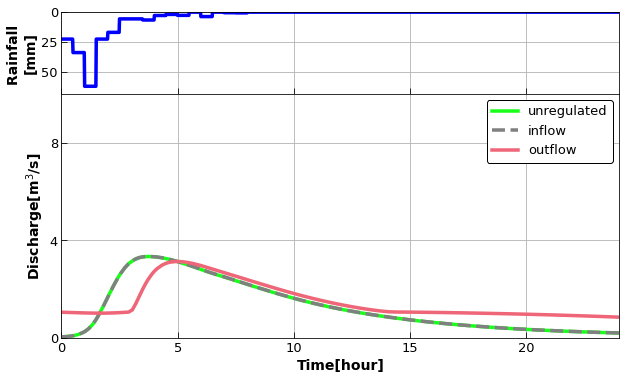

In [105]:
in_out_Kwargs = np.array([{'label':'unregulated', 'color':'#1AFF1A'},{'label':'inflow', 'color':'gray', 'linestyle':'dashed'},{'label':'outflow', 'color':'#ee6677'}],)

dataset = [dc_nodam, dc_passive_S3, out_passive_S3]
plot_sim(dams3[0], forcing, dataset, in_out_Kwargs[[0,1, 2]], d_type='discharge', discharge_axis=[0,10,4],fig_size=(10, 6))

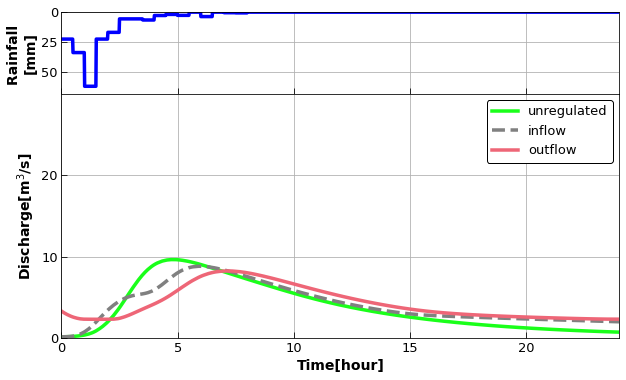

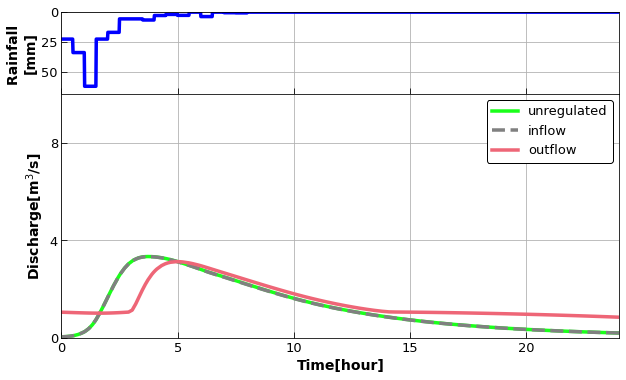

In [106]:
in_out_Kwargs = np.array([{'label':'unregulated', 'color':'#1AFF1A'},{'label':'inflow', 'color':'gray', 'linestyle':'dashed'},{'label':'outflow', 'color':'#ee6677'}],)

dataset = [dc_nodam, dc_passive_S4, out_passive_S4]
plot_sim(dams4[0], forcing, dataset, in_out_Kwargs[[0,1, 2]], d_type='discharge', discharge_axis=[0,30,10],fig_size=(10, 6))
plot_sim(dams4[-1], forcing, dataset, in_out_Kwargs[[0,1, 2]], d_type='discharge', discharge_axis=[0,10,4],fig_size=(10, 6))

In [211]:
from imp import reload 
import hlm_basic.tools
reload(hlm_basic.tools)
from hlm_basic.tools import *

# Trash

In [ ]:
# pltkwargs = np.array([{'label':'nodam', 'color':'#33bbee'}, {'label':'passive', 'color':'#000000',},{'label':'GA', 'color':'#ee3377','alpha':1.0, 'linestyle':'dashed', 'linewidth':2.5},{'label':'extra', 'color':'#490092'}])

In [ ]:
# forcing, raw_data, cum_forcing = GetForcing("../data/rainfall/2018_USCRN_DesMoinesIA.csv", '2018-06-01','2018-10-01', cumulative=True)
# # forcing, raw_data, cum_forcing = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-06-01','2010-09-01', cumulative=True)
# te = len(forcing)-1

In [ ]:
in_out_Kwargs = np.array([{'label':'unregulated', 'color':'#1AFF1A'},{'label':'inflow(regulated)', 'color':'gray'},{'label':'outflow', 'color':'r'}],)

dataset = [dc_nodam,dc_passive,out_passive]
Partial_PLOT(0,1,27, forcing, dataset, in_out_Kwargs,d_type='discharge', discharge_axis=[0,30,10], show_rain=False, fig_size=(10, 10))

In [7]:
def RunSimulation(args):
    ''' Used to run simulation for a given initial time and lead time.
        Output is used to calculate fitness function
    parameters:
        args:list, includes "Watershed" object, t0, forcing, dam_parameters, t_next(lead_time)
    '''

    object, state , t0, forcing, dam_parameters, t_next = args
    object.set_dam_state(states=state)
    discharge, storage = object.Run_256( [t0, t0+t_next], forcing, dam_parameters)
    flow_max = discharge.max(axis=0)
    volume_max = storage.max(axis=0)
    return [flow_max, volume_max]

In [84]:
# watershed object initialization
SSN5 = Watershed(Model=256)
SSN5.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN5.dam_ids = dams
dam_params256 = SSN5.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
# continuous simulation
te=180
update = 60 #mins
lead_time = 60 # the time window used in optimization procedure 
lead_time_opt = 60 # the time window checked if there will be any flooding 
t0 = 0
states_all = [(-60, [1 for _ in range(len(dams))])]
columns = SSN5.__columns__()
dc_ga = pd.DataFrame(columns =columns[0])
st_ga  = pd.DataFrame(columns =columns[1])
while t0 < te-lead_time2:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN5.Get_Snapshot()
    
    #define initial conditions
    SSN5.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    #check if flooding occurs
    data = RunSimulation([SSN5,[1 for _ in range(n_dams)] , t0, forcing, dam_params256, lead_time])
    flow = data[0]

    if flow['8']>31.80/2 or flow['26']>30.40/2 or flow['62']>27.4/2 or flow['89']>16.33/2 or flow['170']>16.33/2:

        population = InitialPopulation2(16, n_dams)
        fitness_all = []
        generation = 0
        while generation<10: # generation
            results = []
            for dam_state in population:
                sim= RunSimulation([SSN5, dam_state , t0, forcing, dam_params256,lead_time_opt])              
                results.append(sim)
            state_previous = states_all[-1][1]
            fitnesses = FitnessCalculator_Scenario_5(results, population, state_previous)
            idx = np.argmax(fitnesses)
            fitness_all.append(fitnesses[idx])
            parents = MatingPoolSelection(population, fitnesses, n_parents=None, selection='best')
            offsprings = Crossover(parents, operator='uniform')        
            offsprings_mutated = MutateOffspring(offsprings, method='scrample', p=0.10)
            population = NewPopulation(parents, offsprings_mutated)
            ##termination
            if generation > 7:
                sub_fitness = fitness_all[-7:]
                if len(set(sub_fitness)) == 1:
                    print(f'[+] Search terminated at generation {generation}')
                    break
            generation +=1
        state = population[idx].astype(float).tolist()
        print('[+]', t0, ' >>> ', state, 'fitness>>', fitnesses[idx])

    else:

        state = [1 for _ in range(n_dams)]
        print(' [-]',t0, ' >>> ', state, )

    states_all.append((t0,state))
    SSN5.set_dam_state(states=state)

    try:
        dc, st = SSN5.Run_256([t0, t0+update], forcing, dam_params256,)
    except IndexError:
        break

    t0 += update
    dc_ga = dc_ga.append(dc)
    st_ga = st_ga.append(st)

Model 256 (254 with_dams) is being used!
 [-] 0  >>>  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[+] 60  >>>  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] fitness>> 0.2846425619890862
120